In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

from joblib import load, dump

import eval_measures as ems

In [2]:
GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

sns.set_context("poster")
sns.set_style("ticks")

In [3]:
def logit(p):
    return np.log(p/(1-p))


def get_empirical_logit(df, X_col, y_col, conditioning_var="Gender",
    bins=None, testing=False):
    if testing:
        # If testing the just print X and y columns
        print X_col, y_col
        return conditioning_var, ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print X_col, conditioning_var, y_col
    t = df.pivot_table(index=pd.cut(df[X_col], bins=bins),
      columns=conditioning_var, values=y_col,
      aggfunc=[np.mean, len])
    t = t.set_index(bins[1:])
    return t


def logistic(x):
    return 1. / (1. + np.exp(-x))

## Load first author data

In [4]:
FA_MODEL_VERSION = "v4"
FA_MODEL_SUFFIX = "%s.first_author" % FA_MODEL_VERSION

results_full_fa = load("results_all_model/%s/results_all_model_intercept.%s.pkl" % (FA_MODEL_VERSION, FA_MODEL_SUFFIX))
TOP_FEATURES_FA = map(lambda x: x[0][0], results_full_fa)

In [5]:
store_path, X_df_path, y_df_path = ("out/Model.%s.h5" % FA_MODEL_SUFFIX), "X", "y"

In [6]:
X_fa = pd.read_hdf(store_path, key=X_df_path, columns=results_full_fa[-1][0][1][1].tables[1].index.tolist())
y_fa = pd.read_hdf(store_path, key=y_df_path)

In [7]:
W_fa = results_full_fa[-1][0][1][1].tables[1]["Coef."]
W_fa.values

array([ -1.95694406e+00,   1.26526986e-01,  -4.43343802e-01,
        -1.69764009e-01,  -1.42065762e+00,  -2.35650111e-01,
         1.61043532e+00,  -9.06158450e-02,   2.66068404e-01,
        -7.86897849e-02,  -9.40437393e-01,  -4.29537559e-01,
         3.28338298e-01,  -7.82644844e-01,  -6.36904575e-01,
        -2.83802350e-01,  -5.56379621e-01,   5.38182511e-01,
         5.38669766e-01,  -1.28108934e+00,   4.56679008e-01,
        -2.80540659e-01,   6.29762183e-02,   5.94925379e-03,
        -2.99663850e-01,  -1.64669898e+00,   8.19846586e-01,
        -2.29401500e-01,  -4.46806278e-02,  -5.24200657e-03,
         2.66947087e-01,   2.38242593e-02,  -4.42545447e-02,
        -1.01039461e-01,  -3.87385597e-03,  -4.11998407e-01,
         8.78802665e-02,  -1.22309544e-01,   6.80756902e-02,
         1.07350476e-01,  -4.36347055e-02,  -6.43979494e-02,
        -1.05847145e-01,   9.48351802e-02,  -2.77387753e-02,
         6.49434448e-01,  -1.84585531e-01,   1.72184370e-04,
         8.23933613e-02,

In [8]:
X_fa.values.shape, W_fa.shape

((41618369, 70), (70,))

In [9]:
y_pred_fa = logistic(np.dot(W_fa, X_fa.values.T))

In [10]:
y_pred_fa.max(), y_pred_fa.min()

(0.95991378785293624, 1.0933938904615942e-07)

## Load last author data

In [29]:
LA_MODEL_VERSION = "v4"
LA_MODEL_SUFFIX = "%s.last_author" % LA_MODEL_VERSION

results_full_la = load("results_all_model/%s/results_all_model_intercept.%s.pkl" % (LA_MODEL_VERSION, LA_MODEL_SUFFIX))
TOP_FEATURES_LA = map(lambda x: x[0][0], results_full_la)

In [30]:
store_path, X_df_path, y_df_path = ("out/Model.%s.h5" % LA_MODEL_SUFFIX), "X", "y"
X_la = pd.read_hdf(store_path, key=X_df_path, columns=results_full_la[-1][0][1][1].tables[1].index.tolist())
y_la = pd.read_hdf(store_path, key=y_df_path)
W_la = results_full_la[-1][0][1][1].tables[1]["Coef."]
W_la.values
X_la.values.shape, W_la.shape

((41618369, 70), (70,))

In [31]:
y_pred_la = logistic(np.dot(W_la, X_la.values.T))
y_pred_la.max(), y_pred_la.min()

(0.8557690318515615, 6.7910062720855437e-07)

## Create precision recall plots

In [14]:
import eval_measures as ems

EMS reloaded


In [32]:
prc = []
prc.append(ems.prc(y_pred_fa, y_fa))
prc.append(ems.prc(y_pred_la, y_la))

In [33]:
roc = []
roc.append(ems.roc(y_pred_fa, y_fa))
roc.append(ems.roc(y_pred_la, y_la))

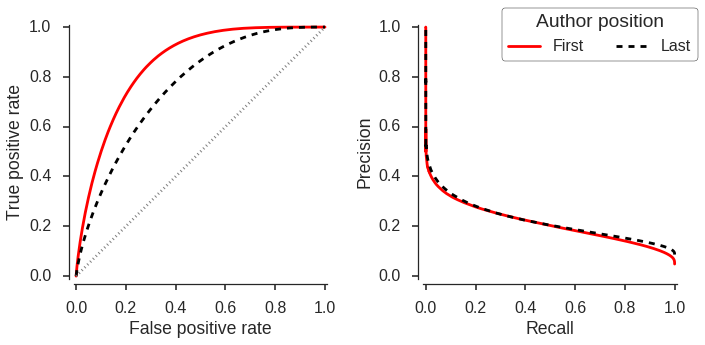

In [44]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
labels = ["First", "Last"]
colors = ["r", "k"]
linestyles = ["-", "--"]
for i, (lbl, c, ls) in enumerate(zip(labels, colors, linestyles)):
    ax[1].plot(prc[i][1], prc[i][0], color=c, linestyle=ls, marker="None", label=lbl)
    ax[0].plot(roc[i][1], roc[i][0], color=c, linestyle=ls, marker="None", label=lbl)

    
ax[0].plot([0,1], [0,1], color="0.5", linestyle=":", marker="None")
ax[0].set_xlabel("False positive rate")
ax[0].set_ylabel("True positive rate")    
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")

lims = [-0.01, 1.01]
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[1].set_xlim(lims)
ax[1].set_ylim(lims)

sns.despine(offset=5)

lgd = fig.legend(*ax[0].get_legend_handles_labels(), ncol=2, loc="upper right", frameon=True, fancybox=True, title="Author position")
fig.tight_layout()
plt.savefig("PRC_ROC.%s.first_last.pdf" % LA_MODEL_VERSION, bbox_inches="tight", bbox_extra_artists=[lgd])

# Opportunity vesus Visibility Plots

## Load first author original data

In [45]:
with pd.HDFStore('out/ModelData.20160529.h5') as cstore:
    df_fa = cstore['first_author']

## Load last author original data

In [46]:
with pd.HDFStore('out/ModelData.20160529.h5') as cstore:
    df_la = cstore['last_author']

## Map predicted probability from models

In [47]:
df_fa["predicted_prob"] = y_pred_fa
df_la["predicted_prob"] = y_pred_la

## Plot the data

In [49]:
y_feature_col = ["is_self_cite", "predicted_prob"]
xcols = ["auth_prev_papers", "source_n_authors", 
         "sink_prev_ncites", "year_span"]

In [66]:
# NEW PARAMS
plot_params_dict = {
    "auth_prev_papers": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], [-0.01, 0.16], "Author's prior papers"],
    "sink_prev_ncites": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], [-0.01, 0.25], "Sink's prior citations"],
    "source_V_novelty": [np.array(range(10) + range(100,10000,100)), "log", [0.95, 10000], None, "Volume novelty of source"],
    "sink_n_mesh_ex": [np.array([-0.1] + range(101)), "linear", [-1, 100], None, "# exploded MeSH in sink"],
    "jj_sim": [np.array([-0.1,0] + range(5,101)), "linear", [-0.1, 101], None, "Journal similarity score"],
    "year_span": [np.array([-10, -1] + range(51)), "symlog", [-1.1, 51], [-0.01, 0.36], "Year Span"],
    "source_ncites": [np.array([-1] + range(201)), "log", [0.9, 201], None, "# references in source"],
    "source_n_authors": [np.array([-0.1] + range(16)), "linear", [0.5,16], [0.04, 0.11], "# authors in source"]
}

source_n_authors None ['is_self_cite', 'predicted_prob']
source_n_authors None ['is_self_cite', 'predicted_prob']


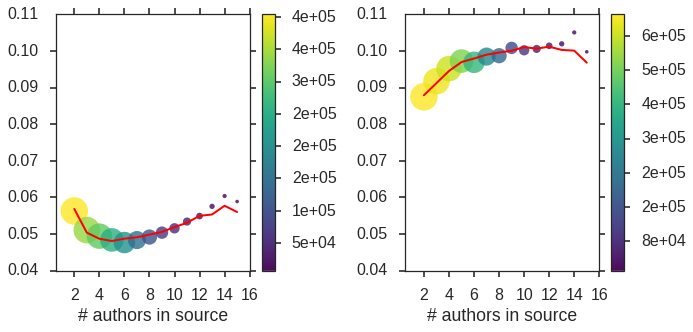

In [59]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('viridis')

xcols = ["auth_prev_papers", "sink_prev_ncites",
         "source_n_authors", "year_span"]

fig, ax = plt.subplots(1,2, figsize=(10,5))
k = "source_n_authors"

bins, xscale, xlims, ylims, xlbl = plot_params_dict[k]

## First author
plot_id = 0
t = get_empirical_logit(df_fa, k, y_feature_col,
    conditioning_var=None,
    bins=bins,
    testing=False)

scp = ax[plot_id].scatter(t.index, np.exp(logit(t["mean"]["is_self_cite"])),
            edgecolor="none",
            s=t["len"]["is_self_cite"]/ 1e4,
            c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
            cmap = cm, alpha=0.8, linewidth=3, marker="o")
line, = ax[plot_id].plot(
    t.index, np.exp(logit(t["mean"]["predicted_prob"])), linestyle="-", color="r", lw=2, alpha=1)
#ylims = [logit(t[yidx]["mean"]["is_self_cite"]).min(), logit(t[yidx]["mean"]["is_self_cite"]).max()]
#lgd_items.append(line)
cb = plt.colorbar(scp, ax = ax[plot_id], format='%.0e')
ax[plot_id].set_xlabel(xlbl)
ax[plot_id].set_xscale(xscale)
ax[plot_id].set_xlim(xlims)
ax[plot_id].set_ylim(ylims)


## First author
plot_id = 1
t = get_empirical_logit(df_la, k, y_feature_col,
    conditioning_var=None,
    bins=bins,
    testing=False)

scp = ax[plot_id].scatter(t.index, np.exp(logit(t["mean"]["is_self_cite"])),
            edgecolor="none",
            s=t["len"]["is_self_cite"]/ 1e4,
            c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
            cmap = cm, alpha=0.8, linewidth=3, marker="o")
line, = ax[plot_id].plot(
    t.index, np.exp(logit(t["mean"]["predicted_prob"])), linestyle="-", color="r", lw=2, alpha=1)
#ylims = [logit(t[yidx]["mean"]["is_self_cite"]).min(), logit(t[yidx]["mean"]["is_self_cite"]).max()]
#lgd_items.append(line)
cb = plt.colorbar(scp, ax = ax[plot_id], format='%.0e')
ax[plot_id].set_xlabel(xlbl)
ax[plot_id].set_xscale(xscale)
ax[plot_id].set_xlim(xlims)
ax[plot_id].set_ylim(ylims)

fig.tight_layout()

First Author:  auth_prev_papers None ['is_self_cite', 'predicted_prob']
Last Author:  auth_prev_papers None ['is_self_cite', 'predicted_prob']
First Author:  sink_prev_ncites None ['is_self_cite', 'predicted_prob']
Last Author:  sink_prev_ncites None ['is_self_cite', 'predicted_prob']
First Author:  source_n_authors None ['is_self_cite', 'predicted_prob']
Last Author:  source_n_authors None ['is_self_cite', 'predicted_prob']
First Author:  year_span None ['is_self_cite', 'predicted_prob']
Last Author:  year_span None ['is_self_cite', 'predicted_prob']


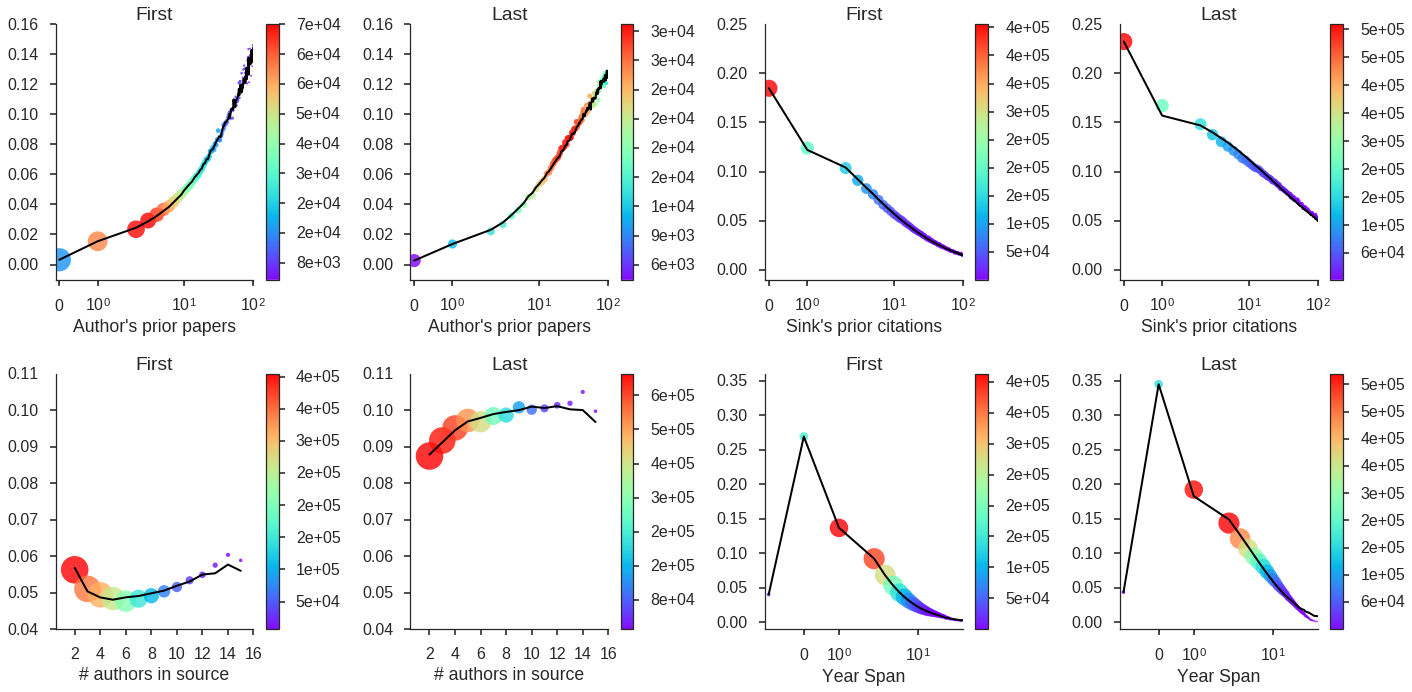

In [70]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('rainbow')
fit_color="k"

xcols = ["auth_prev_papers", "sink_prev_ncites",
         "source_n_authors", "year_span"]

fig, ax = plt.subplots(2,4, figsize=(20,10))
ax = ax.flatten()
for i, k in enumerate(xcols):
    bins, xscale, xlims, ylims, xlbl = plot_params_dict[k]
    ## First author
    print "First Author: ",
    plot_id = 2*i
    t = get_empirical_logit(df_fa, k, y_feature_col,
        conditioning_var=None,
        bins=bins,
        testing=False)

    scp = ax[plot_id].scatter(t.index, np.exp(logit(t["mean"]["is_self_cite"])),
                edgecolor="none",
                s=t["len"]["is_self_cite"]/ 1e4,
                c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
                cmap = cm, alpha=0.8, linewidth=3, marker="o")
    line, = ax[plot_id].plot(
        t.index, np.exp(logit(t["mean"]["predicted_prob"])), linestyle="-", color=fit_color, lw=2, alpha=1)
    #ylims = [logit(t[yidx]["mean"]["is_self_cite"]).min(), logit(t[yidx]["mean"]["is_self_cite"]).max()]
    #lgd_items.append(line)
    cb = plt.colorbar(scp, ax = ax[plot_id], format='%.0e')
    ax[plot_id].set_title("First")
    ax[plot_id].set_xlabel(xlbl)
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    ax[plot_id].set_ylim(ylims)
    # Hide the right and top spines
    ax[plot_id].spines['right'].set_visible(False)
    ax[plot_id].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax[plot_id].yaxis.set_ticks_position('left')
    ax[plot_id].xaxis.set_ticks_position('bottom')
    
    
    ## Last author
    print "Last Author: ",
    plot_id = 2*i + 1
    t = get_empirical_logit(df_la, k, y_feature_col,
        conditioning_var=None,
        bins=bins,
        testing=False)

    scp = ax[plot_id].scatter(t.index, np.exp(logit(t["mean"]["is_self_cite"])),
                edgecolor="none",
                s=t["len"]["is_self_cite"]/ 1e4,
                c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
                cmap = cm, alpha=0.8, linewidth=3, marker="o")
    line, = ax[plot_id].plot(
        t.index, np.exp(logit(t["mean"]["predicted_prob"])), linestyle="-", color=fit_color, lw=2, alpha=1)
    #ylims = [logit(t[yidx]["mean"]["is_self_cite"]).min(), logit(t[yidx]["mean"]["is_self_cite"]).max()]
    #lgd_items.append(line)
    cb = plt.colorbar(scp, ax = ax[plot_id], format='%.0e')
    ax[plot_id].set_title("Last")
    ax[plot_id].set_xlabel(xlbl)
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    ax[plot_id].set_ylim(ylims)
    # Hide the right and top spines
    ax[plot_id].spines['right'].set_visible(False)
    ax[plot_id].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax[plot_id].yaxis.set_ticks_position('left')
    ax[plot_id].xaxis.set_ticks_position('bottom')

fig.tight_layout()

plt.savefig("Opportunity_Visibility.%s.first_last.pdf" % LA_MODEL_VERSION, bbox_inches="tight")